In [36]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [37]:
import speclite
from desisim.io import read_basis_templates

In [40]:
import matplotlib
import seaborn as sns
%matplotlib inline

In [86]:
sns.set(style='white', font_scale=1.8, font='sans-serif')
colors = sns.color_palette('Set2', n_colors=8, desat=0.75)
#colors = iter([_colors[1], _colors[2], _colors[0], _colors[3], _colors[4]])

In [146]:
seed = 1
rand = np.random.RandomState(seed)

### Read the old (v2.2) and new (v3.0) templates

In [87]:
fnew, wnew, mnew = read_basis_templates('STAR')

INFO:io.py:945:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v3.0/star_templates_v3.0.fits


In [88]:
fold, wold, mold = read_basis_templates('STAR', infile=os.path.join(
    os.getenv('DESI_ROOT'), 'spectro', 'templates', 
    'basis_templates', 'v2.6', 'star_templates_v2.2.fits'))

INFO:io.py:945:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.6/star_templates_v2.2.fits


### Coverage of physical parameter space

In [89]:
def qa_physical(new=True):
    
    if new:
        meta = mnew
        title = 'v3.0 Templates'
        col = colors[0]
    else:
        meta = mold
        title = 'v2.2 Templates'
        col = colors[1]
        
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

    ax1.scatter(meta['TEFF'], meta['LOGG'], color=col)
    ax1.set_xscale('log')
    ax1.set_xticks([3000, 5000, 1E4, 2E4])
    ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax1.set_xlabel('$T_{eff}$ (K)')
    ax1.set_ylabel('$\log g$ (cm s$^{-2}$)')
    #ax1.legend(loc='lower right', fontsize=10, markerscale=1.0)

    ax2.scatter(meta['TEFF'], meta['FEH'], color=col)
    ax2.set_xscale('log')
    ax2.set_xticks([3000, 5000, 1E4, 2E4])
    ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax2.set_xlabel('$T_{eff}$ (K)')
    ax2.set_ylabel('[Fe/H]')

    ax3.scatter(meta['LOGG'], meta['FEH'], color=col)
    ax3.set_ylabel('[Fe/H]')
    ax3.set_xlabel('$\log g$ (cm s$^{-2}$)')
    
    fig.suptitle(title, fontsize=18)

    fig.subplots_adjust(wspace=0.22)

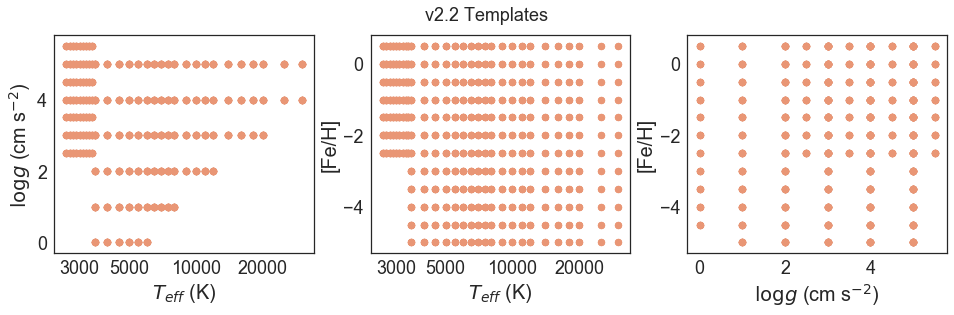

In [90]:
qa_physical(new=False)

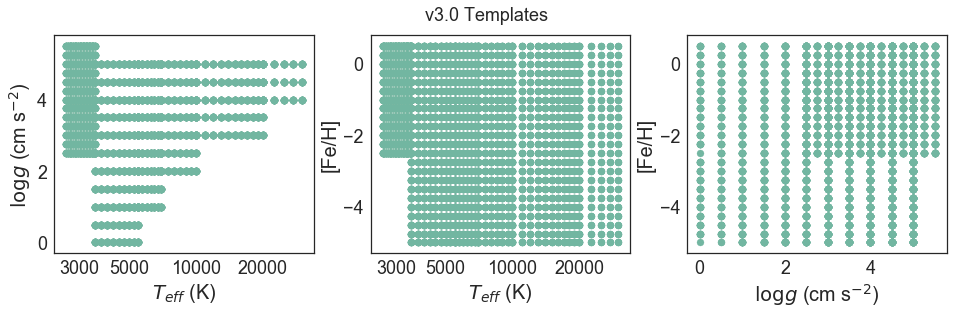

In [91]:
qa_physical()

### Color-color plots

In [28]:
def star_colors(new=True):
    """Read the stellar templates, synthesize photometry, and return colors."""
    if new:
        bands = ('g', 'r', 'z')
        filts = ('decam2014-g', 'decam2014-r', 'decam2014-z')
        filt = speclite.filters.load_filters(*filts)
        flux, wave, meta = fnew, wnew, mnew
    else:
        bands = ('g', 'r', 'z', 'W1', 'W2')
        filts = ('decam2014-g', 'decam2014-r', 'decam2014-z', 'wise2010-W1', 'wise2010-W2')
        filt = speclite.filters.load_filters(*filts)
        flux, wave, meta = fold, wold, mold

    nt = len(meta)
    print('Synthesizing photometry for {} templates.'.format(nt))
    
    phot = filt.get_ab_maggies(flux, wave, mask_invalid=False)
    for ff, bb in zip( phot.colnames, bands ):
        phot.rename_column(ff, bb)
        #synthflux = np.vstack( [phot[ff].data for ff in filts] )
        
    colors = dict(
        r = 22.5 - 2.5 * np.log10(phot['r']),
        gr = -2.5 * np.log10(phot['g'] / phot['r']),
        rz = -2.5 * np.log10(phot['r'] / phot['z']),
        gz = -2.5 * np.log10(phot['g'] / phot['z']))
    
    if 'W1' in bands:
        colors.update( {
            'rW1': -2.5 * np.log10(phot['r'] / phot['W1']),
            'zW1': -2.5 * np.log10(phot['z'] / phot['W1']) } )

    return colors

In [7]:
newcol = star_colors()

INFO:io.py:945:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v3.0/star_templates_v3.0.fits
Synthesizing photometry for 9649 templates.


In [8]:
oldcol = star_colors(new=False)

INFO:io.py:945:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.6/star_templates_v2.2.fits
Synthesizing photometry for 1491 templates.


In [9]:
grrange = (-0.6, 2.2)
gzrange = (0.0, 4.0)
rzrange = (-0.6, 2.8)
zW1range = (-2.5, 0.0)

In [92]:
def qa_colorcolor(pickles=False, pngfile=None):
    
    fig, ax = plt.subplots(figsize=(8, 6))
    if pickles:
        ax.scatter(picklecol['rz'], picklecol['gr'], marker='s', 
                   s=20, linewidth=1, alpha=0.5, label='Pickles+98')#, c='r')
    ax.scatter(newcol['rz'], newcol['gr'], marker='s', color=colors[1],
               s=3, linewidth=1, alpha=1.0, label='v3.0 Templates')#, c='b')
    ax.scatter(oldcol['rz'], oldcol['gr'], marker='o', color=colors[0],
               s=15, linewidth=1, alpha=0.8, label='v2.2 Templates')#, c='b')
    ax.set_xlabel('r - z')
    ax.set_ylabel('g - r')
    ax.set_xlim(rzrange)
    ax.set_ylim(grrange)
    lgnd = ax.legend(loc='upper left', frameon=False, fontsize=18)
    lgnd.legendHandles[0]._sizes = [100]
    lgnd.legendHandles[1]._sizes = [100]
    if pickles:
        lgnd.legendHandles[2]._sizes = [100]
    if pngfile:
        fig.savefig(pngfile)

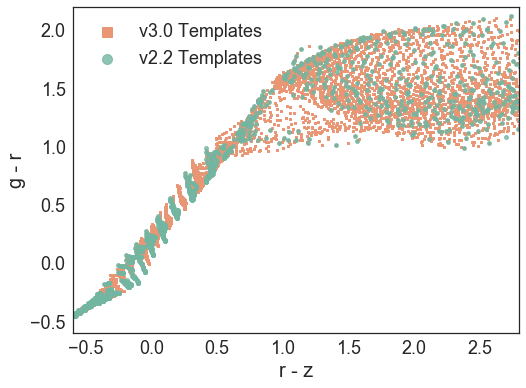

In [93]:
qa_colorcolor(pickles=False)

In [141]:
class star_KDTree(object):
    from scipy.spatial import cKDTree as KDTree

    def __init__(self):
        self.meta_new = mnew
        self.meta_old = mold

        self.param_min_new = ( self.meta_new['TEFF'].min(), 
                               self.meta_new['LOGG'].min(), 
                               self.meta_new['FEH'].min() )
        self.param_min_old = ( self.meta_old['TEFF'].min(), 
                               self.meta_old['LOGG'].min(), 
                               self.meta_old['FEH'].min() )
        
        self.param_range_new = ( np.ptp(self.meta_new['TEFF']), 
                                 np.ptp(self.meta_new['LOGG']),
                                 np.ptp(self.meta_new['FEH']) )
        self.param_range_old = ( np.ptp(self.meta_old['TEFF']), 
                                 np.ptp(self.meta_old['LOGG']),
                                 np.ptp(self.meta_old['FEH']) )
        
        self.tree_new = self.build(new=True)
        self.tree_old = self.build(new=False)

    def build(self, new=True):
        if new:
            meta = self.meta_new
        else:
            meta = self.meta_old
        data = self.rescale(meta)
        return KDTree(data)
        
    def rescale(self, meta, new=True):
        """Normalize to [0, 1]."""
        nt = len(meta)
        if new:
            param_min, param_range = self.param_min_new, self.param_range_new
        else:
            param_min, param_range = self.param_min_old, self.param_range_old
                
        data = np.vstack((meta['TEFF'].data, meta['LOGG'].data, meta['FEH'].data)).T
        datanorm = ( (data - np.tile(param_min, nt).reshape(nt, 3)) / np.tile( param_range, nt).reshape(nt, 3) )
        #datanorm = ( (data - np.tile(np.min(data, axis=0), nt).reshape(nt, 3)) / 
        #  np.tile( (np.max(data, axis=0) - np.min(data, axis=0)), nt).reshape(nt, 3) )
        return datanorm

In [142]:
tree = star_KDTree()

In [139]:
indx = self.tree.query(matrix) # no north-south split (e.g., BGS/MXXL)

In [147]:
def plot_subset(nplot=16, ncol=4, these=None, xlim=None, 
                loc='right', targname='', objtype=''):
    """Plot a random sampling of new and old stellar spectra."""        
    nrow = np.ceil(nplot / ncol).astype('int')

    if loc == 'left':
        xtxt, ytxt, ha = 0.05, 0.93, 'left'
    else:
        xtxt, ytxt, ha = 0.93, 0.93, 'right'

    # Choose a random subset of the old templates and then find 
    # the nearest (in physical parameter space) new template.
    if these is None:
        tree = star_KDTree()    
        these = rand.choice(len(mold), nplot, replace=False)
        these = np.sort(these)
        
        dist, indx = tree.tree_new.query(tree.rescale(tree.meta_old[these], new=True))
        import pdb ; pdb.set_trace()
        
    ww = (wave > 5500) * (wave < 5550)

    fig, ax = plt.subplots(nrow, ncol, figsize=(2.5*ncol, 2*nrow), sharey=False, sharex=True)
    for thisax, indx in zip(ax.flat, these):
        thisax.plot(wave, flux[indx, :] / np.median(flux[indx, ww]))
        if objtype == 'STAR' or objtype == 'WD':
            thisax.text(xtxt, ytxt, r'$T_{{eff}}$={:.0f} K'.format(objtruth['TEFF'][indx]), 
                        ha=ha, va='top', transform=thisax.transAxes, fontsize=13)
        else:
            thisax.text(xtxt, ytxt, 'z={:.3f}'.format(truth['TRUEZ'][indx]), 
                        ha=ha, va='top', transform=thisax.transAxes, fontsize=13)
            
        thisax.xaxis.set_major_locator(plt.MaxNLocator(3))
        if xlim:
            thisax.set_xlim(xlim)
    for thisax in ax.flat:
        thisax.yaxis.set_ticks([])
        thisax.margins(0.2)
        
    fig.suptitle(targname)
    fig.subplots_adjust(wspace=0.05, hspace=0.05, top=0.93)

In [ ]:
plot_subset()

> <ipython-input-147-39c1646a1126>(21)plot_subset()
-> ww = (wave > 5500) * (wave < 5550)
(Pdb) indx
array([ 489, 1401, 2153, 3886, 4813, 4913, 6351, 6443, 7058, 6707, 7390,
       7610, 7640, 8230, 8503, 9622])
(Pdb) tree.meta_old[these]
<Table length=16>
TEMPLATEID   LOGG    TEFF    FEH  
  int32    float32 float32 float32
---------- ------- ------- -------
        91     5.0  2700.0    -2.5
       211     3.5  3000.0     0.0
       330     5.0  3200.0     0.0
       561     4.0  4000.0    -0.5
       683     2.0  5000.0    -2.5
       709     4.0  5000.0    -3.5
       885     2.0  6500.0    -2.5
       909     4.0  6500.0    -2.5
       980     5.0  7000.0    -2.0
      1048     1.0  8000.0     0.0
      1104     5.0  8000.0    -4.0
      1124     3.0  9000.0    -2.0
      1132     4.0  9000.0     0.0
      1237     4.0 11000.0    -4.5
      1301     3.0 14000.0    -0.5
      1481     5.0 30000.0    -0.5
(Pdb) tree.meta_new[indx]
<Table length=16>
TEMPLATEID   LOGG     TEFF     FEH